<a href="https://colab.research.google.com/github/chemoinformatics-lecture/lecture-beginner/blob/main/lesson07_automl/lecture_note_regression_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 行うこと

これまでの授業の復習として以下のことを行ってください。
1. データをダウンロードする
2. Pubchem,RDKit,MOPACなどを用いて説明変数を作成する。
3. 機械学習を用いて、テストデータの予測を行う。
4. テストデータの予測値を課題提出場所に提出してください｡

# pycaretの関数

1. データの前処理：　setup()
2. モデルの比較： compare_models()
3. 分析モデルの生成： create_model()
4. チューニング： tune_model()
5. 可視化： plot_model()
6. 評価： evaluate_model()
7. 予測： finalize_model(), predict_model()

# ライブラリーのインストール

In [1]:
!pip install rdkit
!pip install pycaret==2.2.0
!pip install pandas-profiling==3.1.0
!pip install shap
!pip install scikit-learn==0.23.2 --force-reinstall

# pandas-profilingのversionを落とさないと次のエラーが出る。
# PyCaret ImportError: Missing optional dependency 'Jinja2'
# https://qiita.com/hasegatk/items/c835ba6243efbb4e53d2
# scikit-learn==0.23.2にでないとエラーがでる部分がある。

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 429 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 248 kB 5.3 MB/s 
     |████████████████████████████████| 17.0 MB 205 kB/s 
     |████████████████████████████████| 137 kB 68.4 MB/s 
     |████████████████████████████████| 76.8 MB 1.2 MB/s 
     |████████████████████████████████| 2.0 MB 47.3 MB/s 
     |████████████████████████████████| 1.7 MB 48.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 255.9 MB 43 kB/s 
     |████████████████████████████████| 88 kB 6.6 MB/s 
     |████████████████████████████████| 315 kB 52.1 MB/s 
     |████████████████████████████████| 1.6 MB 67.0 MB/s

# 0. ライブラリーのインポート

In [2]:
import warnings
# 不要な警告文非表示
warnings.filterwarnings("ignore")


In [3]:
import pandas as pd
pd.__version__ # 1.3.5が表示

'1.3.5'

In [4]:
import pycaret
print(pycaret.__version__)  # 2.2.0が表示

2.2.0


In [5]:
import sklearn
print(sklearn.__version__) # 0.23.2が表示

0.23.2


In [6]:
from pycaret.utils import enable_colab
enable_colab()

Colab mode enabled.


# 1. データのセットアップ

In [7]:
!wget 'http://modem.ucsd.edu/adme/data/databases/logS/data_set.dat'

--2022-10-21 07:19:22--  http://modem.ucsd.edu/adme/data/databases/logS/data_set.dat
Resolving modem.ucsd.edu (modem.ucsd.edu)... 132.239.68.159
Connecting to modem.ucsd.edu (modem.ucsd.edu)|132.239.68.159|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 52906 (52K) [text/plain]
Saving to: ‘data_set.dat’

data_set.dat        100%[===================>]  51.67K   181KB/s    in 0.3s    

2022-10-21 07:19:23 (181 KB/s) - ‘data_set.dat’ saved [52906/52906]



In [8]:
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, PandasTools
import numpy as np

# データの呼び出しなど
df = pd.read_csv('data_set.dat', sep='\t', header=None, names = ["smiles", "CAS", "logS"]) 
PandasTools.AddMoleculeColumnToFrame(df, "smiles")
df = df.dropna(subset=['ROMol'], axis=0)
df = df.reset_index()

# fingerprintの作成
fingerprints = []
safe = []
for mol_idx, mol in enumerate(df["ROMol"]):
    try:
        fingerprint = [x for x in AllChem.GetMorganFingerprintAsBitVect(mol, 2, 2048)]
        fingerprints.append(fingerprint)
        safe.append(mol_idx)
        
    except:
        print("Error", mol_idx)
        continue
fingerprints = np.array(fingerprints)
df_fp = pd.DataFrame(fingerprints)

# dfをあわせて表示
df_comb = pd.merge(df, df_fp, left_index=True, right_index=True)

(1289, 2048)


,index,smiles,CAS,logS,ROMol,0,1,2,3,4,...,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,0,O=C(C)N,60-35-5,1.58,,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0

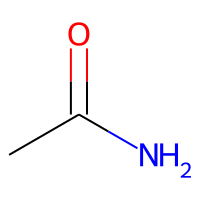

In [9]:
df_comb.head(1)

In [10]:
from pycaret.regression import *
exp1 = setup(df_comb, target = 'logS', ignore_features= ['index', 'smiles', 'CAS', 'ROMol'], silent=True, fold_shuffle=True, session_id=123, train_size=0.9)

# 参考の解説記事
# https://qiita.com/Asagumo63/items/99357d4b472a9219040e
# もとの記事
# https://pycaret.gitbook.io/docs/get-started/quickstart?q=setup#regression

,Description,Value
0,session_id,123
1,Target,logS
2,Original Data,"(1289, 2053)"
3,Missing Values,False
4,Numeric Features,0
5,Categorical Features,2048
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1160, 1929)"


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 0
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['index', 'smiles', 'CAS',
                                                       'ROMol'],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='logS',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_num...
                ('scaling', 'passthrough'), ('P_transform', 'passthrough'),
                ('binn', 'passthrough'), ('rem_outliers', 'passthrough'),

## 学習データの分割や説明変数について確認

In [19]:
X_test = get_config('X_test') # 分割後のテスト用説明変数

INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=X_test)
INFO:logs:Global variable: X_test returned as       1_1  2_1  3_1  4_1  5_0  6_0  7_0  8_1  9_1  10_0  ...  2037_1  2038_1  \
43    0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   1.0  ...     0.0     0.0   
825   0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   1.0  ...     0.0     0.0   
221   1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   1.0  ...     0.0     0.0   
976   0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   1.0  ...     0.0     0.0   
1167  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0   1.0  ...     0.0     0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...     ...     ...   
1201  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   1.0  ...     0.0     0.0   
909   1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   1.0  ...     0.0     0.0   
307   0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   1.0  ...     0.0     0.0   
619   0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   1.0  ...     0.0     0.0   


In [20]:
X_train = get_config('X_train') # 分割後の学習用説明変数

INFO:logs:Initializing get_config()
INFO:logs:get_config(variable=X_train)
INFO:logs:Global variable: X_train returned as       1_1  2_1  3_1  4_1  5_0  6_0  7_0  8_1  9_1  10_0  ...  2037_1  2038_1  \
800   0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   1.0  ...     0.0     0.0   
786   0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   1.0  ...     0.0     0.0   
456   0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   1.0  ...     0.0     0.0   
433   1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   1.0  ...     0.0     0.0   
1037  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   1.0  ...     0.0     0.0   
...   ...  ...  ...  ...  ...  ...  ...  ...  ...   ...  ...     ...     ...   
1238  1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   1.0  ...     0.0     0.0   
1147  1.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   1.0  ...     0.0     0.0   
106   0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   1.0  ...     0.0     0.0   
1041  0.0  0.0  0.0  0.0  1.0  1.0  1.0  0.0  0.0   1.0  ...     0.0     0.0  

# pandas_profiling　重いです。

In [22]:
import pandas_profiling
profile = df_comb.profile_report()

In [ ]:
profile

In [ ]:
profile.to_file("myoutputfile.html")
# このファイルのままだと、一時保存場所なので、時間が経つと消えます。
# ファイルの保存場所をdriveの中にすれば、google driveに保存される。

# 2. モデルの比較： compare_models()

In [26]:
compare_models(fold=3) # デフォルトは、foldが10。時間短縮のために3にしています。

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.8499,1.286400e+00,1.130800e+00,6.887000e-01,0.3127,1.019600e+00,65.8933
rf,Random Forest Regressor,0.8701,1.372100e+00,1.170400e+00,6.656000e-01,0.3184,1.182600e+00,5.4100
br,Bayesian Ridge,0.8839,1.384700e+00,1.173800e+00,6.651000e-01,0.3356,9.588000e-01,3.1167
xgboost,Extreme Gradient Boosting,0.8896,1.431700e+00,1.195700e+00,6.501000e-01,0.3254,1.132600e+00,7.3533
lightgbm,Light Gradient Boosting Machine,0.9160,1.442600e+00,1.200500e+00,6.486000e-01,0.3375,1.091500e+00,0.4833
par,Passive Aggressive Regressor,0.9428,1.523000e+00,1.230400e+00,6.310000e-01,0.3484,1.137700e+00,0.3767
gbr,Gradient Boosting Regressor,0.9710,1.600800e+00,1.262400e+00,6.118000e-01,0.3409,1.385700e+00,1.9433
ridge,Ridge Regression,0.9643,1.675700e+00,1.292800e+00,5.933000e-01,0.3729,1.147200e+00,0.1167
et,Extra Trees Regressor,1.0905,2.152000e+00,1.466900e+00,4.734000e-01,0.4027,1.358800e+00,7.1700
knn,K Neighbors Regressor,1.1490,2.283200e+00,1.508300e+00,4.487000e-01,0.4245,1.353600e+00,1.0300


INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 1
INFO:logs:<catboost.core.CatBoostRegressor object at 0x7fb4612d3350>
INFO:logs:compare_models() succesfully completed......................................


# 3. 分析モデルの生成： create_model()

In [27]:
lr = create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.8103,1.0354,1.0175,0.7721,0.3047,1.5988
1,0.8202,1.0993,1.0485,0.6963,0.3352,0.8883
2,0.8741,1.4047,1.1852,0.6492,0.3080,0.4907
3,0.8387,1.2275,1.1079,0.6418,0.3274,0.8777
4,0.9256,1.6280,1.2759,0.7129,0.3443,1.3536
5,0.7940,1.0782,1.0383,0.7799,0.2834,1.0137
6,0.9193,1.6772,1.2951,0.5757,0.3632,2.1494
7,0.9046,1.4312,1.1963,0.6347,0.3292,1.1842
8,0.8049,1.1896,1.0907,0.5735,0.3168,1.1534
9,0.8165,1.2154,1.1025,0.7194,0.2889,0.8287


INFO:logs:create_model_container: 21
INFO:logs:master_model_container: 21
INFO:logs:display_container: 2
INFO:logs:XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0, ...)
INFO:logs:create_model() succesfully completed......................................


# 4. チューニング： tune_model()

In [28]:
tuned_lr = tune_model(lr, optimize = "r2", fold = 3, n_iter = 5) # デフォルトは、foldが10。時間短縮のために3にしています。n_iterも小さくしています。

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,0.7910,1.1408,1.0681,0.7112,0.3066,0.6246
1,0.8522,1.4388,1.1995,0.7027,0.3148,1.1989
2,0.8810,1.3741,1.1722,0.6222,0.3355,0.9950
Mean,0.8414,1.3179,1.1466,0.6787,0.3189,0.9395
SD,0.0375,0.1280,0.0566,0.0401,0.0122,0.2377


INFO:logs:create_model_container: 22
INFO:logs:master_model_container: 22
INFO:logs:display_container: 3
INFO:logs:XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.323, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0.4, ...)
INFO:logs:tune_model() succesfully completed......................................


# 5. 可視化： plot_model()

In [29]:
plot_model(tuned_lr)

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


# 6. 評価： evaluate_model()

In [30]:
evaluate_model(tuned_lr)

INFO:logs:Initializing evaluate_model()
INFO:logs:evaluate_model(estimator=XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.323, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0.4, ...), fold=None, fit_kwargs=None, feature_name=None, groups=None)


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [33]:
interpret_model(tuned_lr)

INFO:logs:Initializing interpret_model()
INFO:logs:interpret_model(estimator=XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.323, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0.4, ...), plot=summary, feature=None, kwargs={}, observation=None)
INFO:logs:Checking exceptions
INFO:logs:Importing libraries
INFO:logs:plot type: summary
INFO:logs:Creating TreeExplainer
INFO:logs:Compiling shap values
INFO:l

# 7. 予測： finalize_model(), predict_model()

In [54]:
final_lr = finalize_model(tuned_lr)
test_predictions = predict_model(final_lr)
test_predictions

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.323, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0.4, ...), fit_kwargs=None, groups=None, model_only=True, display=None)
INFO:logs:Finalizing XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,0.2593,0.1186,0.3444,0.9689,0.1265,0.2562


,1_1,2_1,3_1,4_1,5_0,6_0,7_0,8_1,9_1,10_0,...,2039_1,2040_0,2042_1,2043_0,2044_1,2045_1,2046_1,2047_0,logS,Label
0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.32,-0.050679
1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-6.27,-6.417165
2,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.38,-0.917530
3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.31,-1.415264
4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-3.70,-3.745361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-4.13,-4.094439
125,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.22,-0.777679
126,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.80,-1.945787
127,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-3.59,-3.507523


In [55]:
plot_model(final_lr)

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [56]:
type(unseen_predictions)

pandas.core.frame.DataFrame

In [57]:
unseen_predictions

,1_1,2_1,3_1,4_1,5_0,6_0,7_0,8_1,9_1,10_0,...,2039_1,2040_0,2042_1,2043_0,2044_1,2045_1,2046_1,2047_0,logS,Label
0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.32,-0.050679
1,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-6.27,-6.417165
2,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.38,-0.917530
3,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.31,-1.415264
4,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-3.70,-3.745361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-4.13,-4.094439
125,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-0.22,-0.777679
126,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-1.80,-1.945787
127,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,-3.59,-3.507523


In [58]:
unseen_predictions.plot(kind='scatter', x='logS', y='Label')
unseen_predictions[['logS', 'Label']]

,logS,Label
0,0.32,-0.050679
1,-6.27,-6.417165
2,-1.38,-0.917530
3,-1.31,-1.415264
4,-3.70,-3.745361
...,...,...
124,-4.13,-4.094439
125,-0.22,-0.777679
126,-1.80,-1.945787
127,-3.59,-3.507523


8. モデルの保存

In [47]:
save_model(final_lr, 'my_best_pipeline')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.323, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=11, max_leaves=0, min_child_weight=4,
             missing=nan, monotone_constraints='()', n_estimators=100,
             n_jobs=-1, num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=123, reg_alpha=0.4, ...), model_name=my_best_pipeline, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                    

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=False,
                                       features_todrop=['index', 'smiles', 'CAS',
                                                        'ROMol'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=[], target='logS',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_num...
                               gamma=0, gpu_id=-1, grow_policy='depthwise',
                               importance_type=None, interaction_constraints='',
                               learning_rate=0.323, max_bin=256,
                           

In [50]:
#load_modelで呼び出せる。
loaded_model = load_model('my_best_pipeline')
print(loaded_model)

INFO:logs:Initializing load_model()
INFO:logs:load_model(model_name=my_best_pipeline, platform=None, authentication=None, verbose=True)


Transformation Pipeline and Model Successfully Loaded
Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=False,
                                      features_todrop=['index', 'smiles', 'CAS',
                                                       'ROMol'],
                                      id_columns=[], ml_usecase='regression',
                                      numerical_features=[], target='logS',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_num...
                              gamma=0, gpu_id=-1, grow_policy='depthwise',
                              importance_type=None, interaction_constraints='',
                              learning_rate=0.323, ma

# 以上です。